In [22]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import wave
#import pyaudio
import numpy as np
#import sounddevice as sd
from utils import *
import scipy
from scipy.signal import iirnotch, filtfilt
from glob import glob
import neurokit2 as nk
from scipy.signal import butter, filtfilt


## Load Data

In [37]:
subject = 'P5070899'
xdf_filename = f'/Users/camilla.strauss/Desktop/CUNY_Data/Data/sub-{subject}/sub-{subject}_ses-S001_task-CUNY_run-001_mobi.xdf'
subject = xdf_filename.split('-')[1].split('/')[0]
ps_df = get_event_data(event='RestingState',
                    df=import_physio_data(xdf_filename),
                    stim_df=import_stim_data(xdf_filename))


## EDA

<Axes: xlabel='time', ylabel='EDA2'>

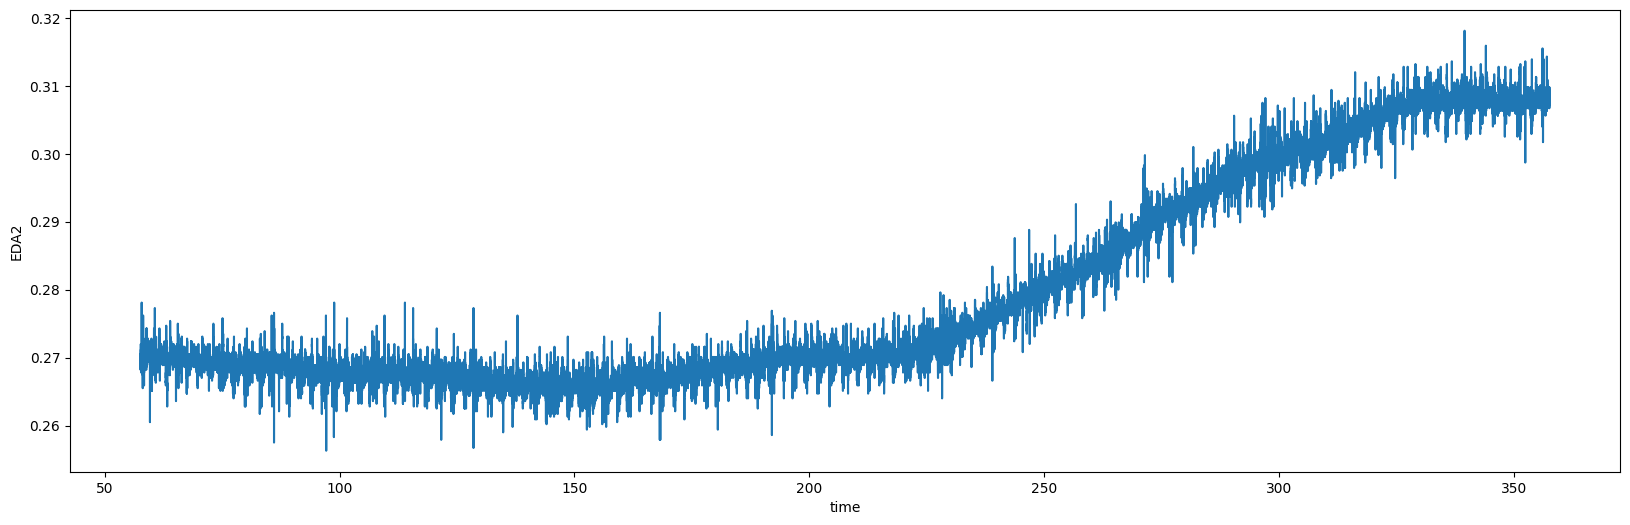

In [38]:
eda_df = ps_df[['EDA2', 'lsl_time_stamp', 'time']]
#ecg_resting_state = get_event_data('RestingState', ecg_df)
fig, ax = plt.subplots(figsize=(20,6))
sns.lineplot(data=eda_df, x='time', y='EDA2')


## QC using neurokit2 package

In [39]:
effective_sampling_rate = 1 / (eda_df.lsl_time_stamp.diff().mean())
print('Effective sampling rate: ', effective_sampling_rate, 'Hz')

Effective sampling rate:  500.14558720325033 Hz


### Signal Integrity Check

In [40]:
# Checking for nan or missing values in EDA data and return a percentage validity

count_nan = 0
for x in eda_df['EDA2']:
    if np.isnan(x) == True:
        count_nan = count_nan + 1

eda_validity = 100 - (count_nan/len(eda_df['EDA2'])) * 100
print('Percentage of valid EDA data: ', eda_validity)

Percentage of valid EDA data:  100.0


### eda_process() - automated pipeline for preprocessing EDA signal, cleaning uses neurokit method

In [41]:
eda_signals, info = nk.eda_process(eda_df['EDA2'], sampling_rate=effective_sampling_rate, method='neurokit')
eda_signals

,EDA_Raw,EDA_Clean,EDA_Tonic,EDA_Phasic,SCR_Onsets,SCR_Peaks,SCR_Height,SCR_Amplitude,SCR_RiseTime,SCR_Recovery,SCR_RecoveryTime
0,0.2693,0.269272,0.269659,-0.000387,0,0,0.0,0.0,0.0,0,0.0
1,0.2689,0.269292,0.269659,-0.000367,0,0,0.0,0.0,0.0,0,0.0
2,0.2701,0.269312,0.269660,-0.000348,0,0,0.0,0.0,0.0,0,0.0
3,0.2693,0.269332,0.269660,-0.000328,0,0,0.0,0.0,0.0,0,0.0
4,0.2682,0.269352,0.269660,-0.000308,0,0,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
150038,0.3082,0.308385,0.307843,0.000005,0,0,0.0,0.0,0.0,0,0.0
150039,0.3082,0.308385,0.307843,0.000005,0,0,0.0,0.0,0.0,0,0.0
150040,0.3090,0.308385,0.307843,0.000005,0,0,0.0,0.0,0.0,0,0.0
150041,0.3082,0.308385,0.307843,0.000004,0,0,0.0,0.0,0.0,0,0.0


## Skin Conductance Level

### Average SCL

In [42]:
# Calculating Mean of Skin Conductance Level (SCL), the tonic component of EDA signal 
scl_signal = eda_signals['EDA_Tonic']
average_scl = np.mean(scl_signal)
print('Average value of SCL: ', average_scl)

Average value of SCL:  0.27968719384851143


### SCL Stability - standard deviation and coefficient of variation of SCL

In [43]:
# Calculating Standard deviation of Skin Conductance Level (SCL), the tonic component of EDA signal 
scl_sd = np.std(scl_signal)
print('Standard Deviation of SCL: ', scl_sd)

# Calculating Coeffecient of Variation of Skin Conductance Level (SCL), the tonic component of EDA signal 
scl_cv = (scl_sd / average_scl) * 100
print('Coefficient of variation of SCL: ', scl_cv, '%')

Standard Deviation of SCL:  0.015196503243459409
Coefficient of variation of SCL:  5.433392582032332 %


### SCL Trend Analysis

In [44]:
# Calculating rolling mean of SCL and slope of rolling mean of SCL over time


rolling_mean = pd.Series(eda_signals['EDA_Tonic']).rolling(window=(int)(effective_sampling_rate), center=True).mean()
slope_rolling_mean = np.gradient(rolling_mean)

# std: variability of slope (fluctuations), mean: magnitude of total slope change (this is what we want)
# rolling range- gets short term variability
rolling_mean_slope_abs = np.abs(slope_rolling_mean).mean()
mean_rolling_mean_slope = pd.Series(slope_rolling_mean).dropna().mean()

print('Mean slope of Rolling Mean: ', mean_rolling_mean_slope)

Mean slope of Rolling Mean:  2.549599437913658e-07


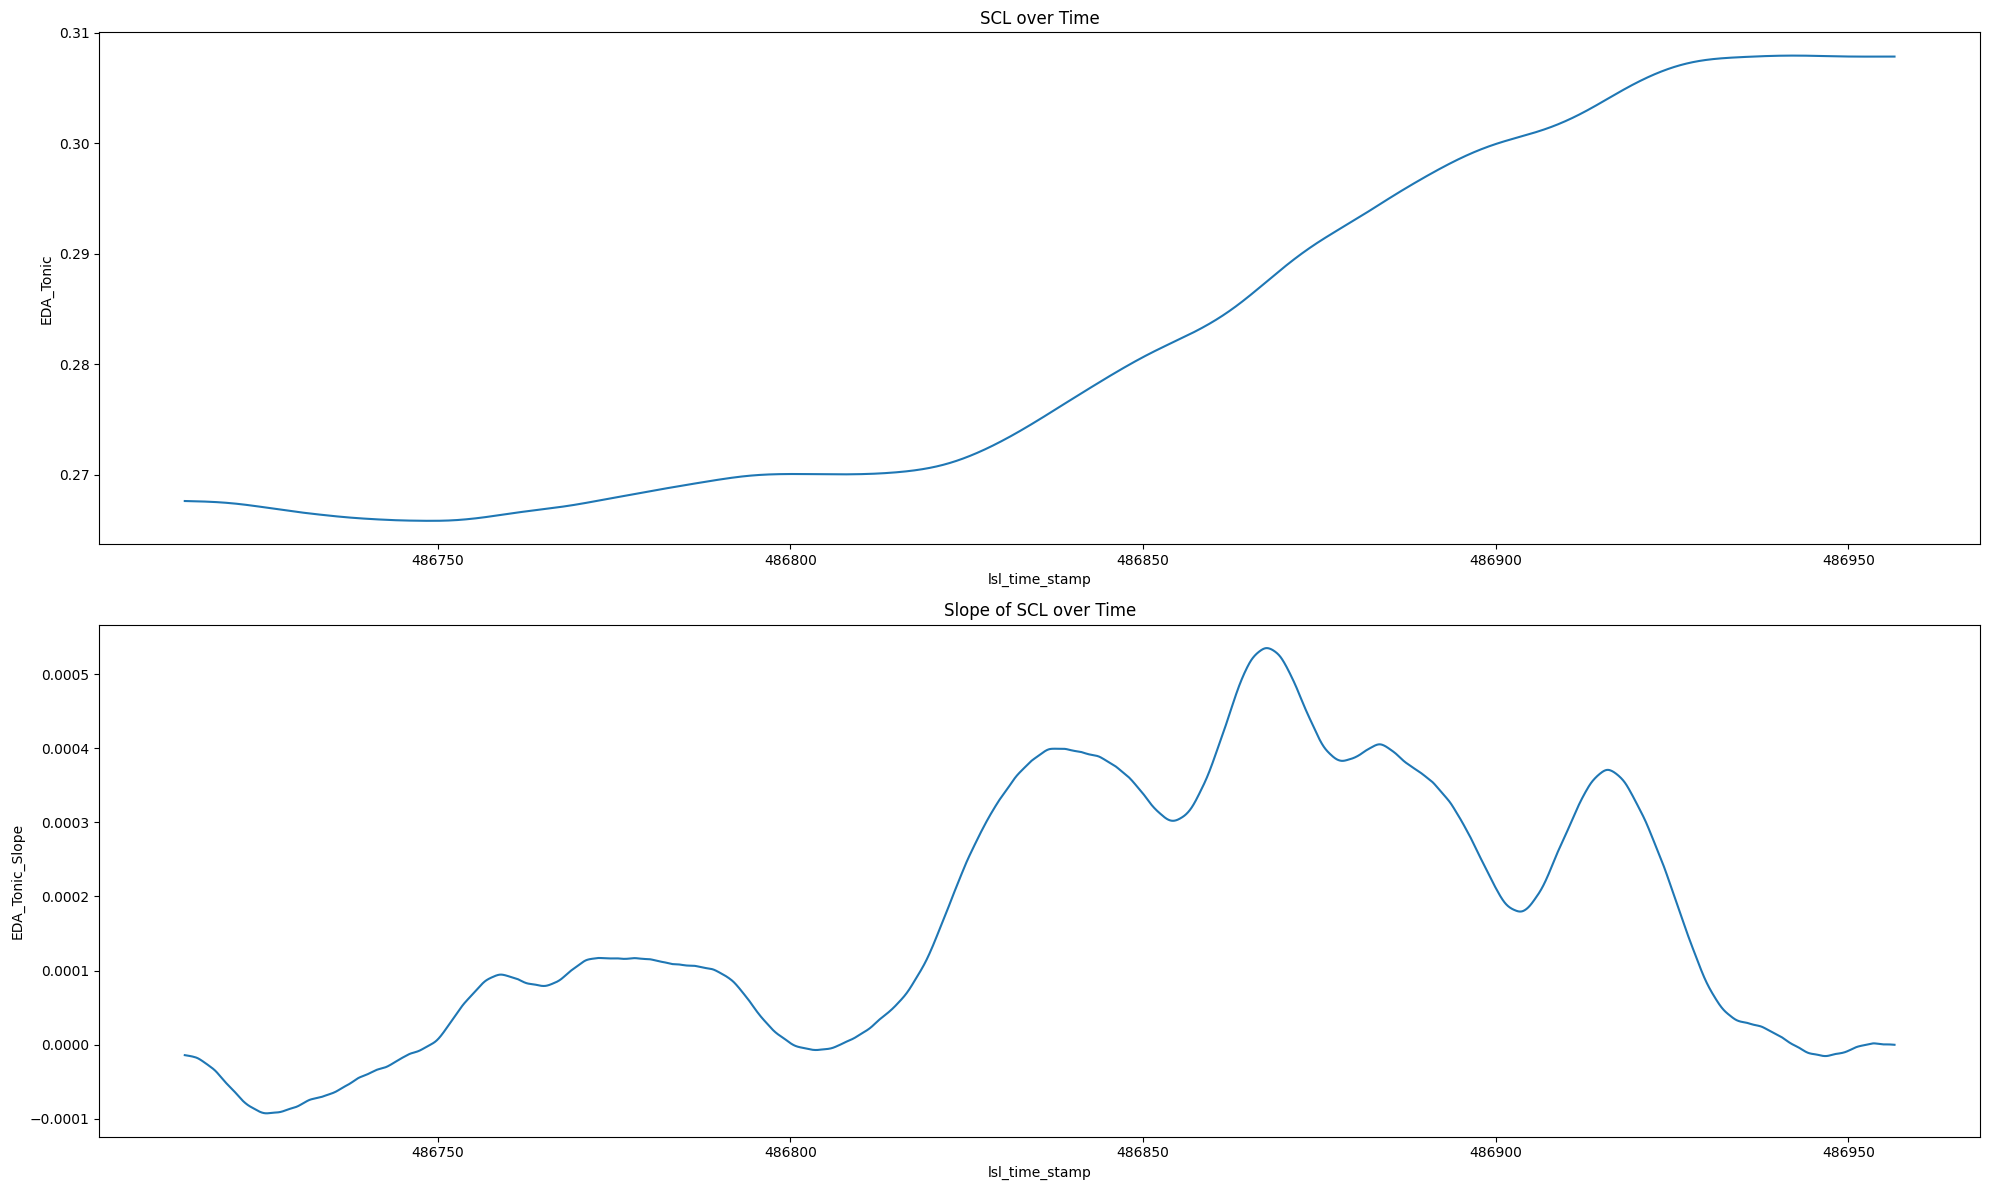

In [45]:
# Calculating slope of SCL over time

scl_df = pd.DataFrame(eda_signals['EDA_Tonic'])
scl_df['lsl_time_stamp'] = eda_df['lsl_time_stamp']
#fig, ax = plt.subplots(figsize=(20,6))
#sns.lineplot(data=scl_df, x='lsl_time_stamp', y='EDA_Tonic')

# Calculating slope of SCL 
scl_df['EDA_Tonic_Slope'] = np.gradient(scl_df['EDA_Tonic'], eda_df['lsl_time_stamp'])

fig, ax = plt.subplots(2, 1, figsize=(20, 12))
sns.lineplot(data=scl_df, x='lsl_time_stamp', y='EDA_Tonic', ax=ax[0])
ax[0].set_title('SCL over Time')

sns.lineplot(data=scl_df, x='lsl_time_stamp', y='EDA_Tonic_Slope', ax=ax[1])
ax[1].set_title('Slope of SCL over Time')

plt.tight_layout()
plt.show()

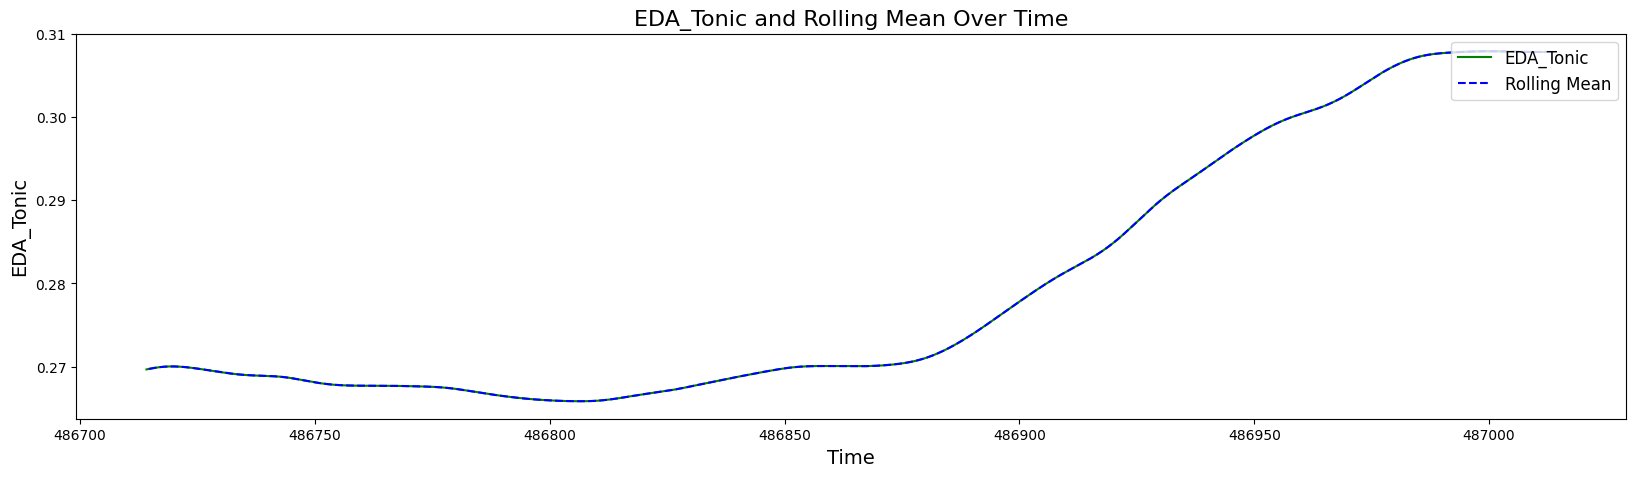

In [46]:
# Visualizing SCL and Rolling mean of SCL over time

plt.figure(figsize=(20,5))
plt.plot(eda_df['lsl_time_stamp'], eda_signals['EDA_Tonic'], label='EDA_Tonic', color='green')
plt.plot(eda_df['lsl_time_stamp'], rolling_mean, label='Rolling Mean', color='blue', linestyle='--')

plt.title('EDA_Tonic and Rolling Mean Over Time', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('EDA_Tonic', fontsize=14)
plt.legend(loc='upper right', fontsize=12)

plt.show()

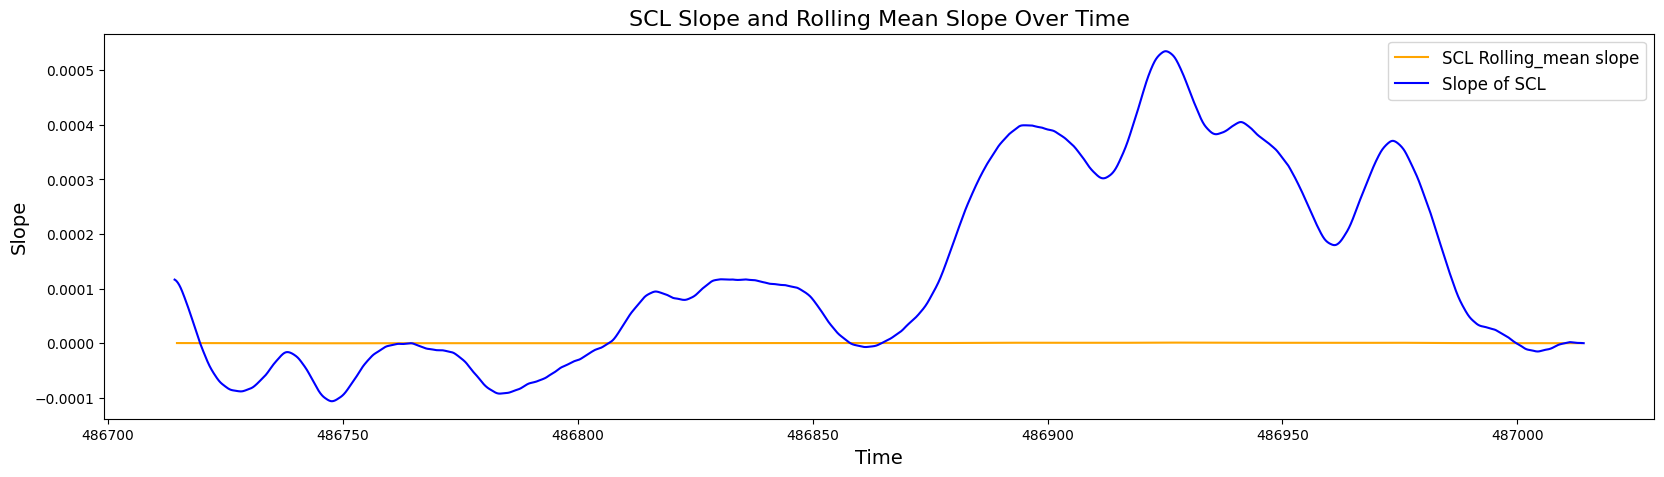

In [47]:
# Comparing slope of SCL over time and slope of SCL rolling mean over time

plt.figure(figsize=(20,5))
plt.plot(eda_df['lsl_time_stamp'], slope_rolling_mean, label='SCL Rolling_mean slope', color='orange', linestyle='-')
plt.plot(eda_df['lsl_time_stamp'], scl_df['EDA_Tonic_Slope'], label='Slope of SCL', color='blue')
plt.title('SCL Slope and Rolling Mean Slope Over Time', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Slope', fontsize=14)
plt.legend(loc='upper right', fontsize=12)

# Show the plot
plt.show()

In [48]:
# low pass filtering standard dev- long term drift estimation 
def lowpass_filter(data, cutoff=0.05, fs=500, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)
lowpass = lowpass_filter(eda_signals['EDA_Tonic'])
print('Standard Deviation of lowpass filter: ', np.std(lowpass))

Standard Deviation of lowpass filter:  0.015196703870141385


## Skin Conductance Response

### Average amplitude of SCRs

In [49]:
scr_amplitudes = [amplitude for amplitude in info['SCR_Amplitude'] if np.isnan(amplitude) != True]
average_scr_amplitude = np.mean(scr_amplitudes)
print('Average amplitude of SCRs: ', average_scr_amplitude)

Average amplitude of SCRs:  0.0014726274747694662


### SCR Amplitude Validity

In [50]:
count_invalid_scr = 0
for amplitude in scr_amplitudes:
    if amplitude > 0.01 and amplitude < 3.0:
        continue
    else:
        count_invalid_scr = count_invalid_scr + 1

scr_amplitude_validity = 100 - (count_invalid_scr/len(scr_amplitudes)) * 100
print('Percentage of valid SCR amplitudes: ', scr_amplitude_validity)


Percentage of valid SCR amplitudes:  0.0


### EDA report plot

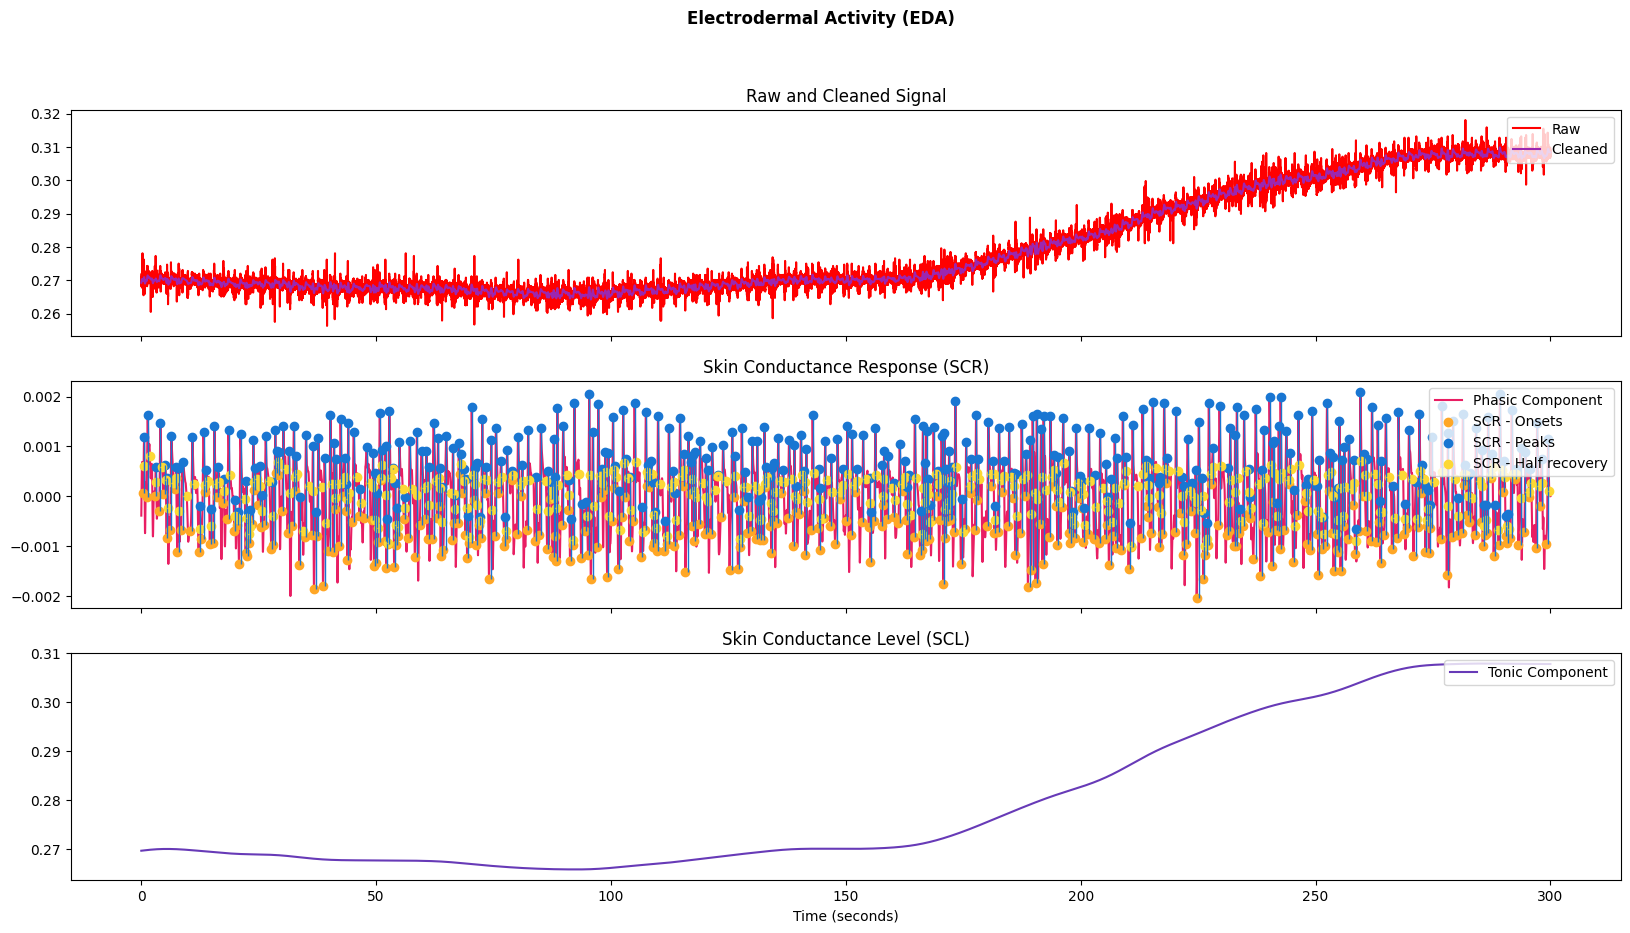

In [51]:
nk.eda_plot(eda_signals, info)
fig = plt.gcf()
axes = fig.get_axes()
fig.set_size_inches(20, 10)
raw_signal_line = axes[0].lines[0]
raw_signal_line.set_color('red')

handles, labels = axes[0].get_legend_handles_labels()
for handle, label in zip(handles, labels):
    if label == "EDA_Raw":  
        handle.set_color('red')  

axes[0].legend(handles, labels)  
axes[0].legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=10)

plt.show()

## SNR calculation for EDA

Signal Power: 0.00023141969489533435
Noise Power: 1.1030113776795349e-06
SNR: 23.21820324417442 dB


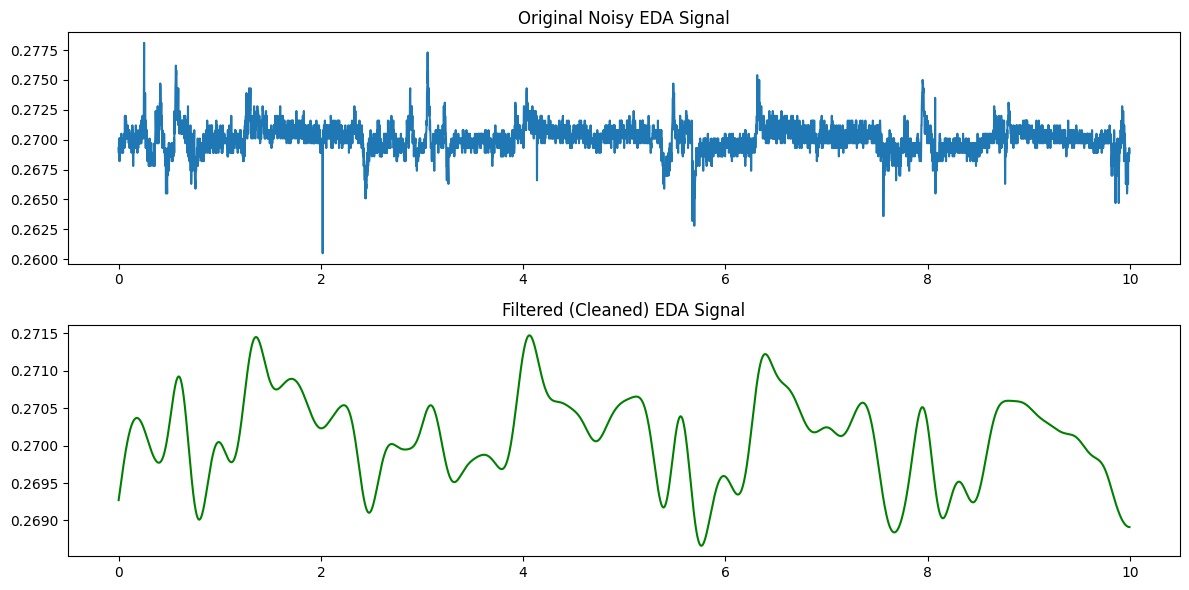

In [52]:
duration = len(eda_df['EDA2'].tolist()) / effective_sampling_rate
t = np.linspace(0, duration , len(eda_df['EDA2']))
t = t[:5000]

# Clean ECG from ecg_signals dataframe
eda_cleaned = eda_signals['EDA_Clean']

# Calculate signal power (variance of the cleaned ECG signal)
signal_power = np.var(eda_cleaned)

# Estimate noise power (using residual noise after subtracting cleaned signal from raw noisy signal)
noise_signal = eda_signals['EDA_Raw'] - eda_cleaned  # residual noise
noise_power = np.var(noise_signal)

# Calculate SNR (Signal-to-Noise Ratio in dB)
snr = 10 * np.log10(signal_power / noise_power)

# Output the results
print(f"Signal Power: {signal_power}")
print(f"Noise Power: {noise_power}")
print(f"SNR: {snr} dB")

# Plot the original noisy signal and the cleaned ECG signal for visualization
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, eda_df['EDA2'].tolist()[:5000], label="Noisy EDA")
plt.title("Original Noisy EDA Signal")
plt.subplot(2, 1, 2)
plt.plot(t, eda_cleaned[:5000], label="Cleaned EDA", color='g')
plt.title("Filtered (Cleaned) EDA Signal")
plt.tight_layout()
plt.show()
